# Social Media Analytics: Detect Food Trends from Facebook Posts

In [1]:
__author__ = "Chris Tran"
__email__ = "tranduckhanh96@gmail.com"
__website__ = "chriskhanhtran.github.io"

## 1. Introduction

In order to detect emerging trends of food consumption from social media data, I employ two simple methods:

- In the first method, I creat **word counts** of each ingredient mentioned in Facebook posts from 01-2015 to 12-2015. For each month, I look at the most mentioned ingredients, then I plot the trend of these ingredients being mentioned over time to detect abrupt changes in the time series. However, with this method, I can only identify the trend of a single ingredient and cannot tell what ingredient it is being mentioned with. For example, I can only see the trend of **cauliflower**, however this trend has a lot of noise because **cauliflower** can be used with any other ingredients, making it hard to detect the rise of **cauliflower rice**.


- In the second method, to handle the limits of the first method, I contruct **co-occurence matrices** of ingredients and calculate **Lift** and **PPMI**. Then, I observe the top 20 ingredient combinations in each month to identify emerging food trends and then plot time-series data to validate these findings. After validating this method on **pumpkin pie**, **cauliflower rice** and **vegetable noodle**, I find it show a fast and accurate detection of food trends.

First, let's load libraries and data that we are going to use in this project.

In [2]:
import os
import re
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
%%time
# Load data
months = list(range(1, 13))
years = list(range(2011, 2016))
data = []
data_index = []
for year in tqdm(years):
    for month in months:
        pathname = f'facebook_posts/fb{year}/fpost-{year}-{month}.csv'
        data_idx = f'{year}-{month}'
        with open(pathname, encoding='utf-8') as f:
            text = f.readlines()
        data.append(text)
        data_index.append(data_idx)

100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


Wall time: 12.2 s


In [4]:
def text_preprocessing(s):
    """
    Preprocess text:
    - Lower the string
    - Remove punctuations
    - Remove '\n'
    - Remove trailing whitespace
    """
    # Lower string
    s = s.lower()
    # Remove punctuation
    s = re.sub(r'[^\w\s]', ' ', s)
    # Remove '\n'
    s = re.sub(r'\n', ' ', s)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).rstrip()
    return s

`ingredients.txt` is a list of more than 1,000 dishes. We will perform some text preprocessing to extract unique ingredients from this list and remove several stop words that are not ingredients. After these processing steps, we have a list of 940 unique ingredients.

In [5]:
# Load ingredient list
with open('facebook_posts/ingredients.txt', encoding='utf-8') as f:
    ingredients = f.readlines()

# Preprocess ingredients
ingredients = list(map(text_preprocessing, ingredients))
# Make a list of unique ingredients
ingredients = list(set([word for item in ingredients for word in item.split()]))
# Sort ingredients alphabetically
ingredients = sorted(ingredients)    

# Remove stop words
stopwords = ['and', 'de', 'of', 's', 'new', 't', 'food']
for stopword in stopwords:
    ingredients.remove(stopword)

# Create word-index dictionary
word2Idx = {w: i for (i, w) in enumerate(ingredients, 0)}

## 2. Trend Detection

As mentioned in the introduction section, below is the implementation of the two methods I use to detect food trends:
- Word Counts
- Co-occurence Matrix, Lift and PPMI

### 2.1. Word Counts

In [6]:
def count_ingredients(data, ingredients):
    """
    @params    data (list): list of list of monthly facebook posts
    @params    ingredients (list): list of 940 ingredients
    @return    ingredient_counts_all (np.array): np.array with shape (940, 60)
    """
    ingredient_counts_all = []
    for monthly_data in tqdm(data):
        # Preprocess text and make a list of all words
        all_words = text_preprocessing(' '.join(monthly_data)).split()
        # Word counts
        word_counts = dict(nltk.FreqDist(all_words))

        # Ingredient counts
        ingredient_counts = pd.Series(index=ingredients, data=np.zeros(len(ingredients)))
        for word in word_counts.keys():
            if word in ingredients:
                ingredient_counts[word] = word_counts[word]

        ingredient_counts_all.append(ingredient_counts.to_numpy())

    ingredient_counts_all = np.stack(ingredient_counts_all).T
    return ingredient_counts_all

ingredient_counts = count_ingredients(data, ingredients)

100%|██████████| 60/60 [07:25<00:00,  7.43s/it]


In [7]:
def plot_ingredient_counts(ingredient):
    """
    Plot the trend of an ingredient from 01-2011 to 12-2015
    @params    ingredient (str): name of an ingredient
    """
    series = pd.Series(ingredient_counts[word2Idx[ingredient], :], index=data_index)
    plt.figure(figsize=(10, 5))
    plt.plot(series)
    plt.xticks([0, 12, 24, 36, 48, 59])
    plt.title(f'Trend of "{ingredient}" from 01-2011 to 12-2015')
    plt.show()

This method detects accurately the trend of **pumpkin**, which is mentioned the most around Thanksgiving. However, it is very hard to use this method to detect new food trends such as **cauliflower rice**, because in this analysis **cauliflower** can be mentioned with any other ingredients and this trend only correlates with the increasing number of Facebook posts.

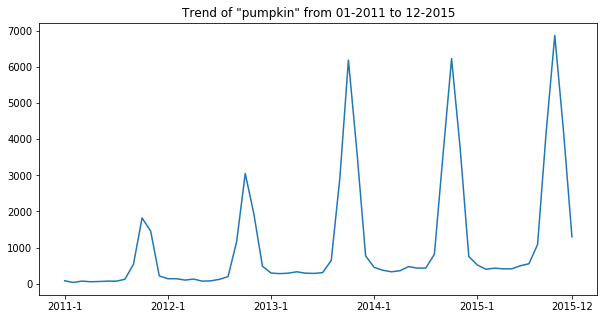

In [8]:
plot_ingredient_counts('pumpkin')

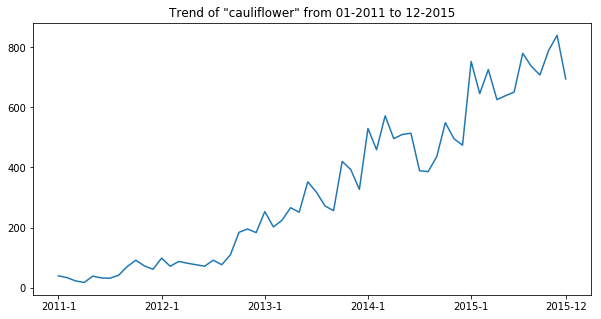

In [9]:
plot_ingredient_counts('cauliflower')

### 2.2 Co-occurence Matrix, Lift and PPMI

In the 2nd method, I creat a co-occurence matrix of 940 ingredients for every month from 01-2011 to 12-2015. Then I stack these 60 matrices into a 3-dimensional array of shape `(60, 940, 940)`. For each month, I look at the 50 most mentioned ingredient combinations to see whether there is any interesting combination being mentioned. Then I examine the trend of these combinations over time to see whether there are abrupt changes.

In [10]:
def cooccurrence_symmetric_window(sentlist, word2Idx, weights):
    """
    Contruct co-occurence matrix from the text data.
    @param    sentlist (list[str]): list of preprocessed string.
    @param    word2Idx (dict): {word: index} dictionary of relevant vocabulary.
    @param    weights (numpy.array): array of weights to specify window size
                and weight for each word in the window.
    @return   res (numpy.array): co-occurence matrix of words in word2Idx.
              Output shape: (len(word2Idx), len(word2Idx))
    """
    # Specify weights and window size
    m = len(weights)
    
    # Specify vocabulary size
    V = len(word2Idx)
    
    # Construct co-occurence matrix
    cooc = np.zeros((V, V), np.float64)
    for sent in sentlist:
        # Preprocess sentence
        sent = text_preprocessing(sent)
        # Tokenize sentence
        words = word_tokenize(sent)
        n = len(words)
        for i in range(n):
            end = min(n - 1, i + m)
            for j in range(i + 1, end + 1):
                if (words[i] in word2Idx.keys() and words[j] in word2Idx.keys()):
                    cooc[word2Idx[words[i]], word2Idx[words[j]]] += weights[j - i - 1]
                    
    # Necessary step since symmetry is exploited to save computation during construction
    res = cooc + cooc.T
    
    # Fill diagonal of co-occurence matrix with 0
    np.fill_diagonal(res, 0.0)
    
    return res

Now we will create co-occurence matrix of ingredients for each month and stack them together to make a 3D array with shape (60, 940, 940).

In [ ]:
# Specify weights
weights = np.array([1, 1, 1, 1, 1])

# Construct co-occurence matrixes
cooc_data = []
for monthly_data in tqdm(data):
    cooc_matrix = cooccurrence_symmetric_window(monthly_data, word2Idx, weights)
    cooc_data.append(cooc_matrix)
    
# Stack outputs together
cooc_data = np.stack(cooc_data)

Let's save the ouput so that we will not have to re-compute the co-occurence matrices in the future.

In [12]:
%%time
# Save co-occurence matrix data
filename = 'cooc_data.npy'
np.save(filename, cooc_data)
# Load co-occurence matrix data
cooc_data = np.load(filename)

Wall time: 4.69 s


With co-occurence matrices, we can compute **Lift** and **PPMI**. These two metrics tell us how much more than by chance two words occur together.

In [14]:
def lift_ppmi(tcm, eps=1e-10):
    """
    Compute Lift and PPMI from co-occurence matrix.
    @param tcm (np.array): 2D array of co-occurence matrix.
    @param eps (float): a very small value to prevent dividing by zero
    @return lift (np.array): 2D array of Lift
    @return ppmi (np.array): 2D array of PPMI
    """
    tcm = np.array(tcm, np.float)
    marginal = np.sum(tcm, axis=0).reshape(-1, 1) + eps
    lift = np.sum(tcm) * tcm / (marginal @ marginal.T)
    ppmi = np.log2(lift * (lift > 1) + (lift <= 1))
    return lift, ppmi

In [15]:
lift_data = []
ppmi_data = []

for month in tqdm(range(60)):
    cooc_matrix = cooc_data[month, :, :]
    lift, ppmi = lift_ppmi(cooc_matrix)
    lift_data.append(lift)
    ppmi_data.append(ppmi)
    
lift_data = np.round(np.stack(lift_data))
ppmi_data = np.round(np.stack(ppmi_data), 4)

100%|██████████| 60/60 [00:03<00:00, 19.88it/s]


Let's define functions to extract indices of the largest values in our data.

In [16]:
def largest_indices(ary, n):
    """
    This function returns the index of n largest number in the 2-dimensional array
    @param    ary (np.array): numpy array to calculate
    @param    n (int): number of top indexes
    @return   new_idx (list): a list of tuple of indexes
    """
    
    flat = ary.flatten()
    indices = np.argpartition(flat, -2*n)[-2*n:]
    indices = indices[np.argsort(-flat[indices])]
    indices = np.unravel_index(indices, ary.shape)
    idx = [(indices[0][i], indices[1][i]) for i in range(2*n)]
    
    # Remove duplicated index
    new_idx = idx.copy()
    for i in range(len(idx)):
        for j in range(i+1, len(idx)):
            if sorted(idx[i]) == sorted(idx[j]):
                new_idx.remove(idx[j])
                
    return new_idx

def check_trend(time, n, matrix):
    """
    This function returns the counts of the top 50 ingredient combination
    @params    time (str): 'yyyy-mm'
    @params    n (int): Return n ingredient combinations
    @params    matrix (np.array): 2D array of the matrix to check trend
    @return    print a data frame of top n ingredient combinations
    """
    time_idx = data_index.index(time)
    matrix = matrix[time_idx, :, :]
    idx = largest_indices(matrix, n)
    
    foods_count = {}
    for i in idx:
        foods_count[f'{ingredients[i[0]]} - {ingredients[i[1]]}'] = matrix[i]
    foods_count = pd.DataFrame(pd.Series(foods_count), columns=['count']).reset_index()
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(foods_count)

Below is an example of the top 10 ingredient combinations being mentioned in Facebook posts on November 2014 from the co-occurence matrix. Ingredient combinations from the co-occurence matrix are regular foods/ingredients like **pepper salt**, **ice cream** or **chocolate cake**. We can identify some foods that are special for November, such as **pumpkin pie**. However, it is hard to detect new trends from these results.

In [17]:
check_trend('2014-11', 10, cooc_data)

              index   count
0     pepper - salt  1285.0
1    cheese - cream  1158.0
2   peanut - butter  1116.0
3       olive - oil  1080.0
4    potato - sweet  1053.0
5     pie - pumpkin   992.0
6  chocolate - cake   851.0
7     brown - sugar   746.0
8    black - pepper   717.0
9       cream - ice   715.0


On the other hand, results from **lift** data tell us interesting combinations that are rare to see such as **guinea fowl**, **chervil blini** and **bresaola fleur**. These results show up approximately 20,000 times more than by chance. **PPMI** data basically tells us the same thing. With the lift data, we can just look at the top results in each month to identify new trends, and verify these trends by plotting time-series. 

In [18]:
check_trend('2014-11', 10, lift_data)

                    index    count
0           guinea - fowl  22284.0
1         chervil - blini  21184.0
2        bresaola - fleur  17874.0
3  mangosteen - preserved  12999.0
4          perch - cavolo  12710.0
5           nero - cavolo  12710.0
6               sum - dim  12624.0
7         emmental - edam  10999.0
8            ras - hanout  10999.0
9     nasturtium - sorrel   9533.0


In [19]:
check_trend('2014-11', 10, ppmi_data)

                    index    count
0           guinea - fowl  14.4437
1         blini - chervil  14.3707
2        fleur - bresaola  14.1256
3  preserved - mangosteen  13.6661
4           nero - cavolo  13.6337
5          perch - cavolo  13.6337
6               sum - dim  13.6239
7         edam - emmental  13.4251
8            ras - hanout  13.4251
9     sorrel - nasturtium  13.2187


<img src="https://download.ams.birds.cornell.edu/api/v1/asset/106991351/1800" alt="Guineafowl" width="300">
<p style="text-align: center;">Guineafowl - Look like a good alternative for Turkey in Thanksgiving</p>
<img src="https://chowhound1.cbsistatic.com/thumbnail/1200/0/chowhound1.cbsistatic.com/assets/models/promotions/photos/29666/original/cornmeal-blini-recipe-chowhound.jpg" alt="Chervil Blini" width="300">
<p style="text-align: center;">Chervil Blini - Pile a little salmon roe and fresh chervil on top. Why not?</p>
<img src="https://live.staticflickr.com/1455/25152261069_3bf73d763f_b.jpg" alt="Bresaola Fleur" width="300">
<p style="text-align: center;">Bresaola Fleur - Do you want to try it?</p>



## 3. Validation

Now we will plot time-series from 2011-1 to 2015-12 of some foods we discover to verify our findings.

In [20]:
def plot_trend(food, data=cooc_data):
    """
    @params    food (str): name of a potential two-word food
    @params    data (np.array): an array of 3D data to plot from
    @return    plot the trend of `food` from 01-2011 to 12-2015
    """
    word1 = food.split()[0].lower()
    word2 = food.split()[1].lower()
    series = pd.Series(data[:, word2Idx[word1], word2Idx[word2]], index=data_index)
    plt.figure(figsize=(15, 5))
    plt.plot(series)
    plt.xticks([0, 12, 24, 36, 48, 59])
    plt.title(f'Trend of "{food}" from 01-2011 to 12-2015')
    plt.show()

**Vegetable Noodle and Cauliflower Rice**

There were spikes of **Vegetable Noodle** in **January 2012** and from **October 2014** to **December 2014**. It makes sense because after that, in January 2015, Vogue (American edition) featured this trend in its Lifestyle section.

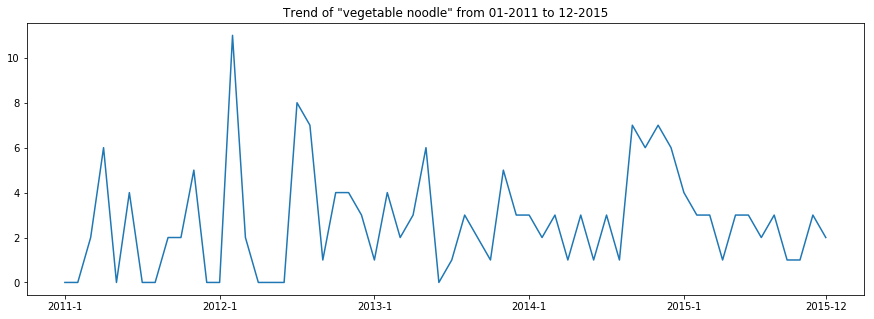

In [21]:
plot_trend('vegetable noodle', lift_data)

The trend of **Cauliflower Rice** is also portrayed in the below plot. The number of mentions of **Cauliflower Rice** started to increase in January 2014 and peaked in 2015.

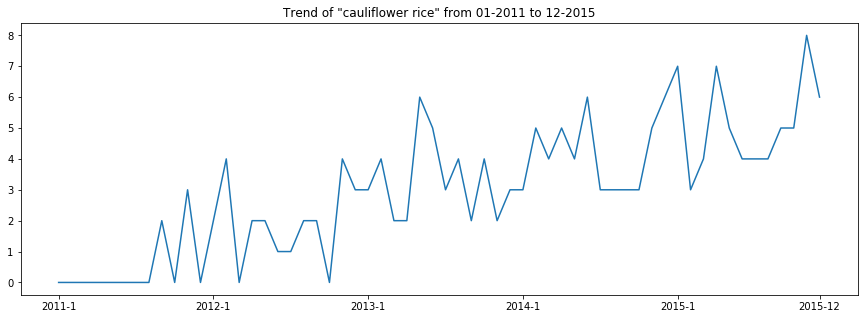

In [22]:
plot_trend('cauliflower rice', lift_data)

**Thanksgiving foods**

The trends of foods consumed in Thanksgiving are clearly portrayed in co-occurence matrix data. In below graphs, we can see the mentions of **pumpkin pie**, **mashed potatoes**, **cranberry sauce** and **squash butternut** peaked around November but remained low in other seasons.

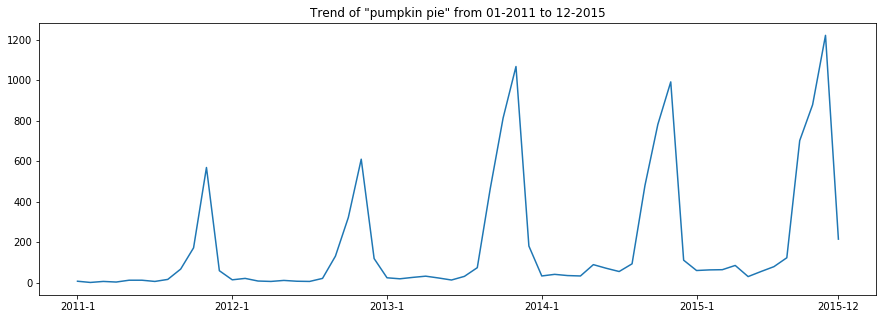

In [23]:
plot_trend('pumpkin pie', cooc_data)

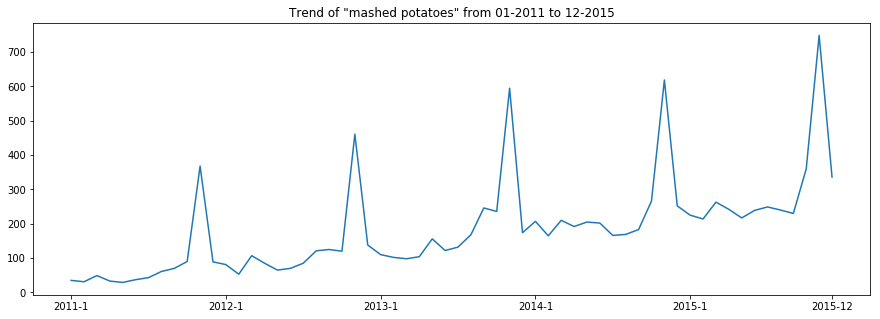

In [24]:
plot_trend('mashed potatoes', cooc_data)

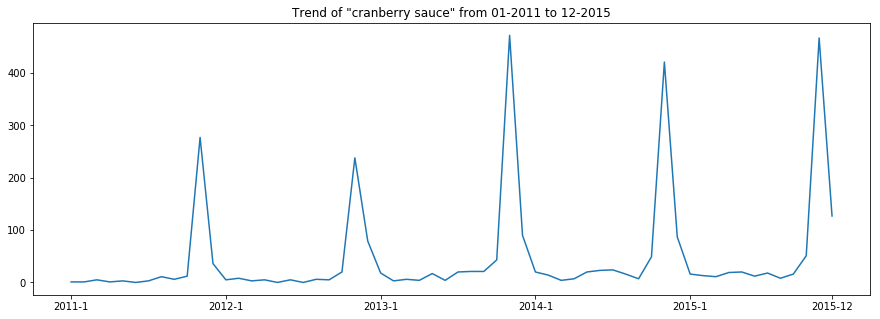

In [25]:
plot_trend('cranberry sauce', cooc_data)

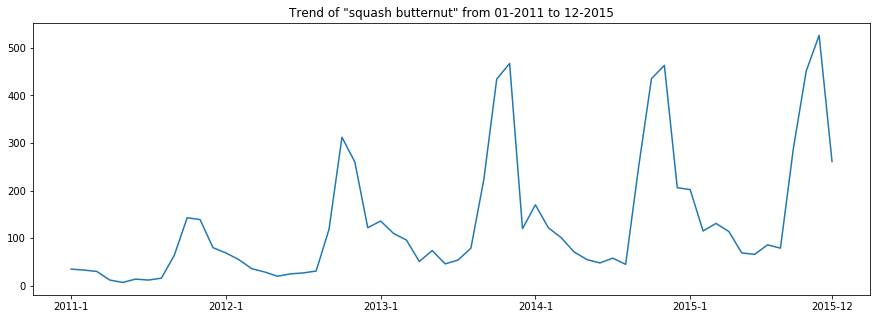

In [27]:
plot_trend('squash butternut', cooc_data)

One interesting thing to be noticed from above graphs is that different foods have different patterns, but these patterns repeat at the same time every year.

**Interesting Findings**

Let's look at time-series plots of some foods we discovered in Section 2.

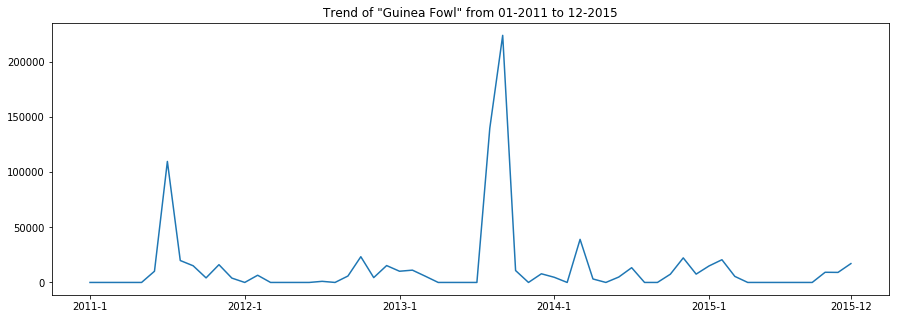

In [28]:
plot_trend('Guinea Fowl', lift_data)

`Guinea Fowl` spiked on June 2011 and November 2013. What was interesting then?

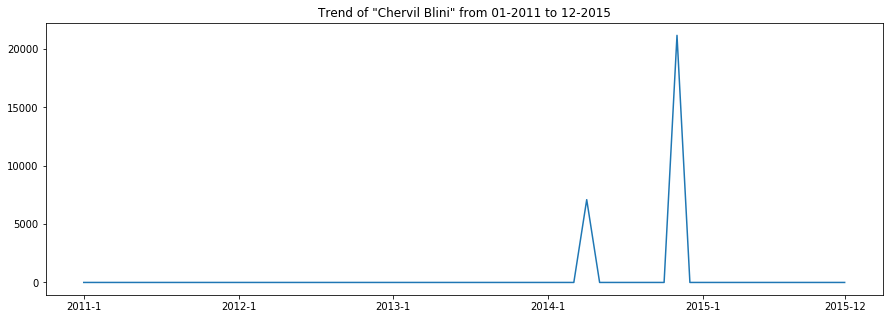

In [29]:
plot_trend('Chervil Blini', lift_data)

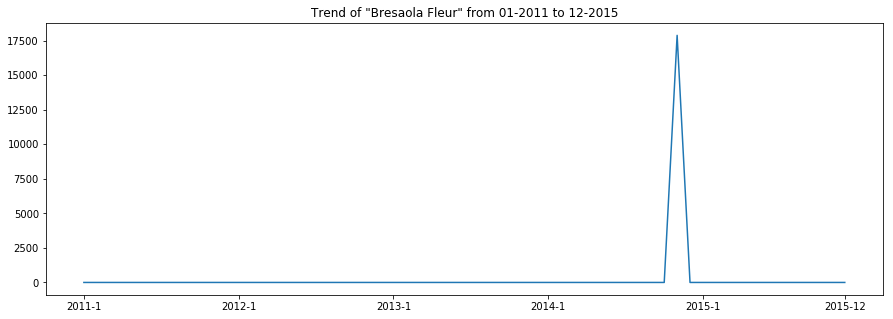

In [30]:
plot_trend('Bresaola Fleur', lift_data)

Interestingly, we picked up the very few times **Chervil Blini** and **Bresaola Fleur** showed up in our data. This indicates that after we discover any interesting foods emerging from our analysis, we have to perform validation to make sure they are really emerging trends that worth investing in. Plotting time-series data is a good way to validate our findings. Additionally, we can conduct surveys to understand how consumers perceive potentially new foods.

## 4. Conclusion

The word-count method is simple and straightforward, however the results are very noisy, making it hard to detect any interesting combinations of ingredients that are being mentioned on social media. Co-occurence matrix helps us observing the trends of specific ingredient combinations, but to identify any new trend we need to spend much time mining our results because the results from co-occurence matrix mostly show popular foods.

The most effective way is to calculate Lift or PPMI from our constructed co-occurence matrices. These metrics tell us how much more than by chance we observe pair of ingredients showing up together in Facebook posts. With this method we can detect interesting and rare foods. However, we need to validate our findings by plotting time-series data or conducting surveys before putting these foods into production.